## **EX 2 - Classifying the data :)**

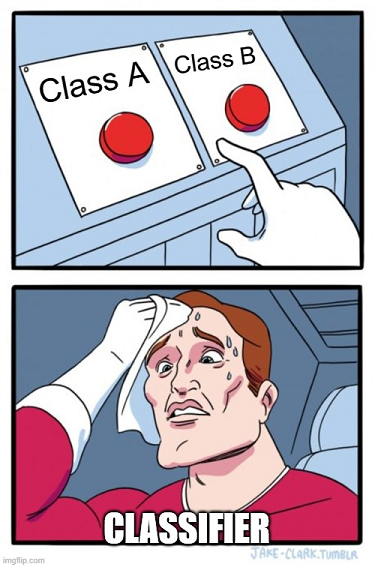
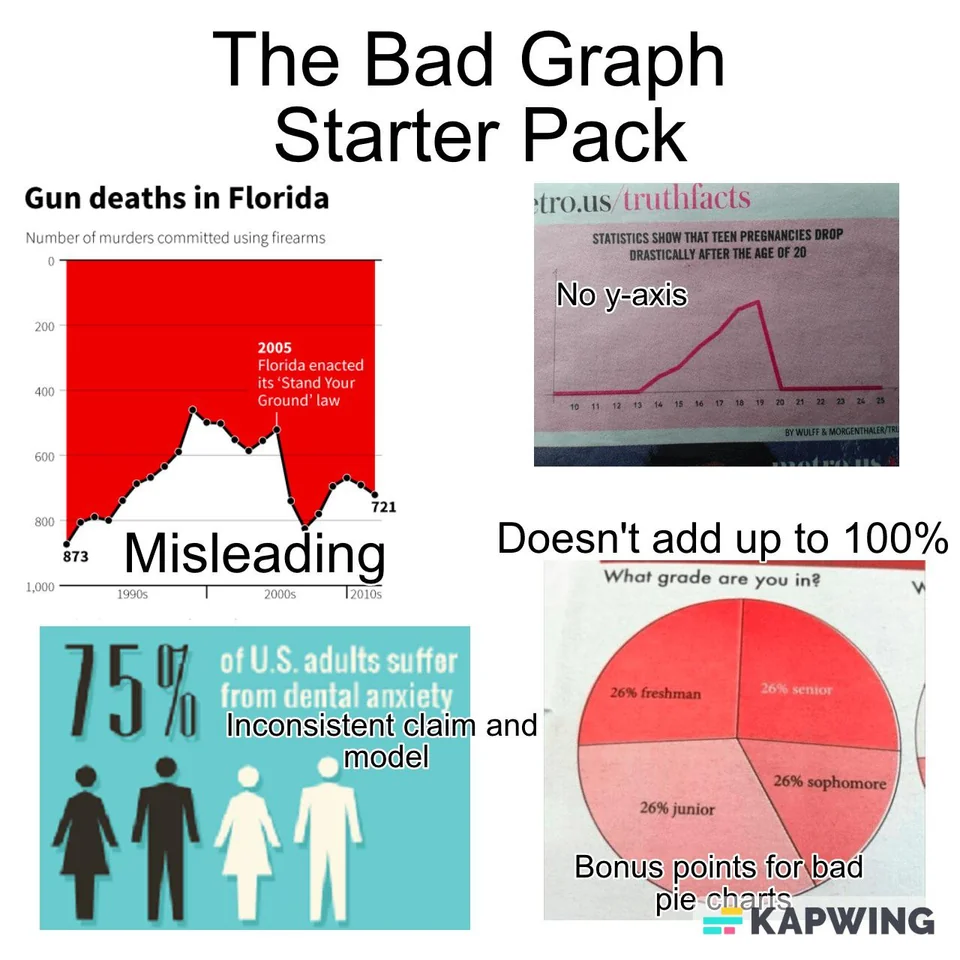

## These are important imports

In [1]:
import sys
if not (sys.version_info.major == 3 and sys.version_info.minor >= 6):
    print("WARNING: OUTDATED PYTHON VERSION")
!py -3.8 -m pip --version
!py -3.8 -m pip install -r req.txt

pip 21.0.1 from C:\Users\gilad\AppData\Local\Programs\Python\Python38-32\lib\site-packages\pip (python 3.8)

^C


In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from random import choice, sample
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics  
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import export_graphviz
from IPython.display import Image  
#import pydotplus

from time import sleep
from IPython.display import display, HTML

import re

In [3]:
sb.set(color_codes=True, rc={'figure.figsize': (5, 5)})
COLUMNS_IS_CATEGORY = "is_software	is_web	is_mobile	is_enterprise	is_advertising	is_gamesvideo	is_ecommerce	is_biotech	is_consulting	is_othercategory".split('\t')
COLUMNS_IN_STATE = "in_CA	in_NY	in_MA	in_TX	in_otherstate".split('\t')
ROUNDS = "roundA	roundB	roundC	roundD".split('\t')

### Reading the CSV file:

In [4]:
data_frame_train = pd.read_csv("../part-1/startup_dataset.csv")
data_frame_test = pd.read_csv("./test_data.csv")

dfs2clean = {'test': data_frame_test, 'train': data_frame_train}

## 1) Pre-processing - LIKE PART 1
### Data cleaning - check for each one of the problems and take care of them properly, e.g., missing values,  inconsistent  etc. 

#### Missing values

In [5]:
def check_cleanness(df) -> None:
    are_all_good = True
    for title in df.columns:
        if df[title].isnull().sum() > 0:
            are_all_good = False
            print(f"titles {title} is {choice('dirty.smells.cheesy.ugly.stinky.boring'.split('.'))}")
    if are_all_good:
        print("Cleaning is done. All good!")

def create_country_col(df):
    for code in ['CA', 'NY', 'MA', 'TX', 'otherstate']:
        df.loc[df[f'in_{code}'] == 1, 'country'] = code

def fill_missing_vals(df):
    """
    fill missing values in country and first/last_milestone_age columns (same as part one)
    """
    # fill missing values in country column
    missing_country = df[df['country'].isnull()]
    for index in missing_country.index:
        state_code = df.loc[index, 'state_code']
        if state_code in ['CA', 'NY', 'MA', 'TX']:
            df.loc[index, 'country'] = state_code
        else:
            df.loc[index, 'country'] = 'otherstate'
    
    # fill missing values in the first/last_milestone_age columns
    null_indices = df['first_milestone_age'].isnull() | df['last_milestone_age'].isnull()

    df.loc[null_indices, 'first_milestone_age'] = df.loc[null_indices, 'last_milestone_age'] = df['first_milestone_age'].mean()
    # create a new column to indicate if the startup has milestones or not
    df.loc[null_indices, 'no_milestones'] = 1
    df.loc[~null_indices, 'no_milestones'] = 0

    print("All missing values are filled!")


In [6]:
for df in dfs2clean.values():
    create_country_col(df)

let's check which columns are dirty... (has missing values :\ )

In [7]:
for n, df in dfs2clean.items():
    print(f"Before filling missing values - {n}")
    check_cleanness(df)
    print()

Before filling missing values - test
titles first_milestone_age is boring
titles last_milestone_age is ugly

Before filling missing values - train
titles first_milestone_age is boring
titles last_milestone_age is boring
titles country is ugly



Same as part one we can see that the columns: 'country', 'first_milestone_age', 'last_milestone_age' have missing values.   
So we will fill them - 'country' according to the state_code, and the other two with the mean of the column, and we will create a new column 'no_milestone' that will be 1 if there is no milestone and 0 otherwise - that is because the missing values in the 'first_milestone_age' and 'last_milestone_age' columns are because there is no milestone, so we want to keep this information.

In [8]:
for df in dfs2clean.values():
    fill_missing_vals(df)

All missing values are filled!
All missing values are filled!


In [9]:
# let's check again
for n, df in dfs2clean.items():
    print(f"After filling missing values - {n}")
    check_cleanness(df)
    print()

After filling missing values - test
Cleaning is done. All good!

After filling missing values - train
Cleaning is done. All good!



#### Inconsistent data

First we can check if the state_code is consistent with the in_(state_code) values in the data_frame_test, changing the in_(state_code) according to the state_code.

In [10]:
def check_binary_inconsistency(df, columns, label):
    association_word = columns[0][:2]
    for index in df[label].index:

        # x = data_frame_test.loc[index, columns].values#.sum()# == 1
        # x = next((col for (col, val) in zip(columns, x) if val==1)).strip("in_")
        category_code = df.loc[index, label].replace('_', '')
        good_code = f"{association_word}_{category_code}" if f"{association_word}_{category_code}" in columns else columns[-1]
    
        if df.loc[index, good_code] == 1:
            if df.loc[index, columns].values.sum() == 1:  # we have only one 1 :)
                continue
            else:  # we have more than one 1 :(
                df.loc[index, columns] = [0]*len(columns)
                df.loc[index, good_code] = 1  # save the good one

        else:  # we don't have a one in the good column
            print(f"wrong values at id={df.loc[index, 'id']}. fixing now...", end=" ")
            right_value = [0]*len(columns)
            right_value[columns.index(good_code)] = 1
            df.loc[index, columns] = right_value
            sleep(0.5)
            print("done.")
    
    print("All good! No more inconsistency.")

In [11]:
for n, df in dfs2clean.items():
    print(f"checking inconsistency in {n} data - state_code")
    check_binary_inconsistency(df, COLUMNS_IN_STATE, "state_code")
    print()

checking inconsistency in test data - state_code
All good! No more inconsistency.

checking inconsistency in train data - state_code
wrong values at id=c:856. fixing now... done.
All good! No more inconsistency.



As we stated before, we had one inconsistent value in the state_code column (we observed it thanks to the country column we added), so we changed it to the correct value.

Secondly, we can check if the category is consistent with the is_(category) values in the data_frame_test, changing the is_(category) according to the category.

In [12]:
for n, df in dfs2clean.items():
    print(f"checking inconsistency in {n} data - category")
    check_binary_inconsistency(df, COLUMNS_IS_CATEGORY, "category")
    print()

checking inconsistency in test data - category
All good! No more inconsistency.

checking inconsistency in train data - category
All good! No more inconsistency.



We can also check the cities for inconsistency - here we also use the code from part 1

In [13]:
for n, df in dfs2clean.items():
    print(f"The cities in {n} data")
    x = np.sort(df["city"].unique())
    print("\n".join(x))
    print()

The cities in test data
Acton
Addison
Aliso Viejo
Altamonte Springs
Arcadia
Austin
Avon
Bellevue
Berkeley
Bothell
Boulder
Brisbane
Burlington
Cambridge
Campbell
Carlsbad
Chelmsford
Chicago
Cleveland
Columbus
Cupertino
Dallas
Denver
El Segundo
El Segundo,
Emeryville
Foster City
Fremont
Hampton
Hollywood
Houston
Idaho Falls
Indianapolis
Kenmore
La Jolla
Laguna Niguel
Lancaster
Lisle
Little Rock
Los Angeles
Los Gatos
McLean
Menlo Park
Middleton
Mountain View
New York
Newton
Palo Alto
Pasadena
Pleasanton
Portland
Providence
Provo
Redmond
Redwood City
San Carlos
San Diego
San Francisco
San Jose
San Mateo
San Rafael
Santa Clara
Santa Monica
Scotts Valley
Seattle
South San Francisco
Sunnyvale
Tempe
Thousand Oaks
Toledo
Torrance
Waltham
Westport
Yorba Linda

The cities in train data
Addison
Alameda
Albuquerque
Aliso Viejo
Allentown
Alpharetta
Andover
Annapolis
Arlington
Atlanta
Austin
Bala Cynwyd
Bedford
Bellevue
Belmont
Berkeley
Berwyn
Bethesda
Bethlehem
Beverly Hills
Billerica
Bingham Farms


We found some duplicates in the data (and typos :P), so we'll merge them into the same city.

In [14]:
def check_cities(df):
    """Check for and fix inconsistency in cities column"""
    # from part-1
    inconsistency_cities = {'New York City': "NYC.NY.New York", 'Atlanta': 'NW Atlanta',
    'Hollywood': 'North Hollywood.West Hollywood', 'Reading': "North Reading", "Billerica": "North Billerica",
    "Spokane": "SPOKANE", 'San Francisco': "San Franciso.South San Francisco", "Sunnyvale": "Sunnnyvale", "Chester": "West Chester", 
    "Hollywood": "West Hollywood", "Newfield": "West Newfield"}

    for key, values in inconsistency_cities.items():
        for fix_from in values.split('.'):
            df.loc[df['city']==fix_from, "city"] = key

    # new things from this part
    for index in df.index:
        df.loc[index, "city"] = re.sub(r'[^a-zA-Z ]+', '', df.loc[index, "city"])  # remove all non-alphabetic characters

    print("All good! No more inconsistency.")

for n, df in dfs2clean.items():
    print(f"checking inconsistency in {n} data")
    check_cities(df)
    print()

checking inconsistency in test data
All good! No more inconsistency.

checking inconsistency in train data
All good! No more inconsistency.



In [15]:
for n, df in dfs2clean.items():
    print(f"The cities in {n} data - after fixing")
    x = np.sort(df["city"].unique())
    print("\n".join(x))
    print()

The cities in test data - after fixing
Acton
Addison
Aliso Viejo
Altamonte Springs
Arcadia
Austin
Avon
Bellevue
Berkeley
Bothell
Boulder
Brisbane
Burlington
Cambridge
Campbell
Carlsbad
Chelmsford
Chicago
Cleveland
Columbus
Cupertino
Dallas
Denver
El Segundo
Emeryville
Foster City
Fremont
Hampton
Hollywood
Houston
Idaho Falls
Indianapolis
Kenmore
La Jolla
Laguna Niguel
Lancaster
Lisle
Little Rock
Los Angeles
Los Gatos
McLean
Menlo Park
Middleton
Mountain View
New York City
Newton
Palo Alto
Pasadena
Pleasanton
Portland
Providence
Provo
Redmond
Redwood City
San Carlos
San Diego
San Francisco
San Jose
San Mateo
San Rafael
Santa Clara
Santa Monica
Scotts Valley
Seattle
Sunnyvale
Tempe
Thousand Oaks
Toledo
Torrance
Waltham
Westport
Yorba Linda

The cities in train data - after fixing
Addison
Alameda
Albuquerque
Aliso Viejo
Allentown
Alpharetta
Andover
Annapolis
Arlington
Atlanta
Austin
Bala Cynwyd
Bedford
Bellevue
Belmont
Berkeley
Berwyn
Bethesda
Bethlehem
Beverly Hills
Billerica
Bingham Far

All good now :)

We can also check if the funding ages are consistent with the funding dates and foundation dates (should be the difference between them).

In [16]:
def check_ages(df, age_col, date_col, ref_col):
    """Check if the age is consistent with the date according to the reference column"""
    # first we transform the date to a datetime object of pandas - this will help us to calculate the age :)
    frmt = '%m/%d/%Y'
    df['foundation_date'] = pd.to_datetime(df['foundation_date'], format=frmt)
    df['first_funding_date'] = pd.to_datetime(df['first_funding_date'], format=frmt)
    df['last_funding_date'] = pd.to_datetime(df['last_funding_date'], format=frmt)

    for index in df[age_col].index:
        if df.loc[index, age_col] != round((df.loc[index, date_col] - df.loc[index, ref_col]).days / 365, 4):  # age need to be the difference between the dates
            print(f"wrong values fixing now... ", end=" ")
            df.loc[index, age_col] = round((df.loc[index, date_col] - df.loc[index, ref_col]).days / 365, 4)  # fix the age
            sleep(0.5)
            print("done.")
    print(f"All good! No more inconsistency in the {age_col} column.")

# now fix the first_funding_age and last_funding_age columns
for n, df in dfs2clean.items():
    print(f"Checking inconsistency in {n} data - first_funding_age, last_funding_age")
    check_ages(df, 'first_funding_age', 'first_funding_date', 'foundation_date')
    check_ages(df, 'last_funding_age', 'last_funding_date', 'foundation_date')
    print()

Checking inconsistency in test data - first_funding_age, last_funding_age
All good! No more inconsistency in the first_funding_age column.
All good! No more inconsistency in the last_funding_age column.

Checking inconsistency in train data - first_funding_age, last_funding_age
All good! No more inconsistency in the first_funding_age column.
All good! No more inconsistency in the last_funding_age column.



We can also check the rounds for inconsistency - total funding rounds should be at least the sum of the other rounds.

In [18]:
def check_funding_rounds(df):
    """Check if the funding_rounds column is consistent with the other funding columns"""
    for index in df['funding_rounds'].index:
        if df.loc[index, ROUNDS].sum() > df.loc[index, 'funding_rounds']:
            print("wrong values fixing now... ", end=" ")
            df.loc[index, 'funding_rounds'] = df.loc[index, ROUNDS].sum()
            sleep(0.5)
            print("done.")

    print("All good! No more inconsistency in the funding_rounds column.")

for n, df in dfs2clean.items():
    print(f"checking inconsistency in {n} data - funding_rounds")
    check_funding_rounds(df)
    print()

checking inconsistency in test data - funding_rounds
All good! No more inconsistency in the funding_rounds column.

checking inconsistency in train data - funding_rounds
All good! No more inconsistency in the funding_rounds column.



#### Outliers

In [19]:
def find_outliers(df, col, positive=False):
    mean = df[col].mean()
    std = df[col].std()
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    good_lower_bound = max(0, lower_bound) if positive else lower_bound
    return good_lower_bound, upper_bound, df[(df[col] < good_lower_bound) | (df[col] > upper_bound)]  # return the outliers

In [21]:
OUTLIERS_CHECK_COLS = ['total_funding', 'connections', 'funding_rounds', 'milestones', 'avg_group_size']

def print_outliers(df):
    """Print for outliers in the given dateframe"""
    for col in OUTLIERS_CHECK_COLS:
        l_bound, u_bound, outliers = find_outliers(df, col, True)
        print(f"Outliers for {col}:\n\tlower bound: {l_bound}\n\tupper bound: {u_bound}")
        display(HTML(outliers.to_html()))
        print("\n")
    
for n, df in dfs2clean.items():
    print(f"checking outliers in {n} data")
    print_outliers(data_frame_train)
    print()

checking outliers in test data
Outliers for total_funding:
	lower bound: 0
	upper bound: 662578420.2063695


,id,state_code,latitude,longitude,zip_code,city,name,foundation_date,first_funding_date,last_funding_date,first_funding_age,last_funding_age,first_milestone_age,last_milestone_age,connections,funding_rounds,total_funding,milestones,in_CA,in_NY,in_MA,in_TX,in_otherstate,category,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,roundA,roundB,roundC,roundD,avg_group_size,in_Top500,Target,country,no_milestones
364,c:13219,WA,30.63248,-86.984345,98033,Kirkland,Clearwire,2003-10-01,2008-05-06,2013-02-27,4.6,9.4164,5.2575,9.7753,19,4,5700000000,2,0,0,0,0,1,mobile,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4.25,1,acquired,otherstate,0.0




Outliers for connections:
	lower bound: 0
	upper bound: 30.070518032500324


,id,state_code,latitude,longitude,zip_code,city,name,foundation_date,first_funding_date,last_funding_date,first_funding_age,last_funding_age,first_milestone_age,last_milestone_age,connections,funding_rounds,total_funding,milestones,in_CA,in_NY,in_MA,in_TX,in_otherstate,category,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,roundA,roundB,roundC,roundD,avg_group_size,in_Top500,Target,country,no_milestones
28,c:36920,TX,30.265344,-97.743586,78701,Austin,"RetailMeNot, Inc.",2007-05-01,2009-11-01,2011-11-10,2.5068,4.5315,4.931500,5.676700,37,5,299500000,2,0,0,0,1,0,web,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1.7500,1,acquired,TX,0.0
54,c:109,CA,37.787084,-122.403805,94103,San Francisco,Mashery,2006-05-01,2007-01-01,2012-07-23,0.6712,6.2329,4.049300,7.597300,37,6,34700000,4,1,0,0,0,0,enterprise,0,0,0,1,0,0,0,0,0,0,1,1,1,1,5.0000,1,acquired,CA,0.0
216,c:3288,CA,33.972790,-118.427578,90094,Playa Vista,WebVisible,2001-01-01,2005-09-01,2010-02-11,4.6685,9.1178,9.753400,12.802700,33,3,37000000,4,1,0,0,0,0,software,1,0,0,0,0,0,0,0,0,0,1,1,1,0,1.3333,1,closed,CA,0.0
230,c:48640,TX,33.068275,-96.711101,75023,Plano,Auvitek International,2004-03-01,2006-05-09,2006-05-09,2.1890,2.1890,3.094282,3.094282,32,1,9000000,0,0,0,0,1,0,semiconductor,0,0,0,0,0,0,0,0,0,1,0,1,0,0,4.0000,1,closed,TX,1.0
308,c:4,CA,37.764726,-122.394523,94107,San Francisco,Digg,2004-10-11,2005-10-01,2011-07-12,0.9726,6.7534,5.246600,9.153400,57,4,45000000,8,1,0,0,0,0,news,0,0,0,0,0,0,0,0,0,1,1,1,1,1,4.6667,1,acquired,CA,0.0
322,c:23756,GA,33.786263,-84.387794,30309,Atlanta,Zipcar,2000-10-31,2002-12-20,2010-12-15,2.1370,10.1288,10.416400,12.186300,35,4,60704370,3,0,0,0,0,1,transportation,0,0,0,0,0,0,0,0,0,1,0,1,0,1,2.0000,1,acquired,otherstate,0.0
358,c:10054,MA,42.368633,-71.075305,2210,Boston,Jumptap,2005-01-01,2005-03-01,2012-07-02,0.1616,7.5041,7.052100,8.619200,45,7,121500000,3,0,0,1,0,0,mobile,0,0,1,0,0,0,0,0,0,0,1,1,1,1,4.5000,1,acquired,MA,0.0
391,c:1285,MA,42.346743,-71.076632,2116,Boston,Compete,2000-01-01,2000-11-01,2007-08-01,0.8356,7.5863,11.589000,13.586300,35,4,33000000,5,0,0,1,0,0,consulting,0,0,0,0,0,0,0,0,1,0,1,1,1,0,2.5000,1,acquired,MA,0.0
407,c:1388,NY,40.729839,-73.991781,10003,New York City,The Huffington Post,2005-05-09,2005-05-01,2010-08-01,-0.0219,5.2329,5.761600,7.487700,31,5,37000000,3,0,1,0,0,0,news,0,0,0,0,0,0,0,0,0,1,1,1,1,0,2.5000,1,acquired,NY,0.0
490,c:63,CA,37.627971,-122.426804,94066,San Bruno,YouTube,2005-02-01,2005-11-01,2006-04-01,0.7479,1.1616,2.400000,8.838400,63,2,11500000,6,1,0,0,0,0,games_video,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1.0000,1,acquired,CA,0.0




Outliers for funding_rounds:
	lower bound: 0
	upper bound: 6.4939842068953855


,id,state_code,latitude,longitude,zip_code,city,name,foundation_date,first_funding_date,last_funding_date,first_funding_age,last_funding_age,first_milestone_age,last_milestone_age,connections,funding_rounds,total_funding,milestones,in_CA,in_NY,in_MA,in_TX,in_otherstate,category,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,roundA,roundB,roundC,roundD,avg_group_size,in_Top500,Target,country,no_milestones
39,c:1224,NY,40.755446,-73.980246,10010,New York City,Peer39,2006-03-01,2006-03-01,2012-01-24,0.0000,5.9041,3.841100,7.137000,18,7,29915001,5,0,1,0,0,0,advertising,0,0,0,0,1,0,0,0,0,0,1,1,1,0,2.7500,1,acquired,NY,0.0
79,c:31514,MA,42.375100,-71.105616,2138,Cambridge,AccelGolf,2008-08-01,2008-01-01,2009-12-04,-0.5836,1.3425,0.000000,1.547900,4,7,457282,2,0,0,1,0,0,mobile,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0000,1,closed,MA,0.0
154,c:5264,CA,38.279431,-122.668452,94954,Petaluma,Dilithium Networks,2001-01-01,2003-04-23,2010-06-03,2.3068,9.4247,4.498600,11.416400,12,7,98170000,3,1,0,0,0,0,mobile,0,0,1,0,0,0,0,0,0,0,0,1,1,1,5.2000,1,closed,CA,0.0
251,c:44,NY,37.480999,-122.173887,10016,New York City,Jingle Networks,2005-09-01,2005-10-01,2009-12-28,0.0822,4.3260,3.663000,5.611000,12,7,88651133,5,0,1,0,0,0,mobile,0,0,1,0,0,0,0,0,0,0,1,1,1,1,3.1667,1,acquired,NY,0.0
302,c:24029,NY,40.728425,-73.999882,10012,New York City,Blip,2005-05-01,2006-03-01,2012-07-30,0.8329,7.2521,8.005500,8.400000,23,7,27300000,4,0,1,0,0,0,games_video,0,0,0,0,0,1,0,0,0,0,1,1,1,1,2.0000,1,acquired,NY,0.0
314,c:6340,WA,39.783730,-100.445882,98104,Seattle,Cozi Group,2005-03-03,2005-12-01,2012-12-27,0.7479,7.8247,4.315100,5.904100,16,7,26390819,3,0,0,0,0,1,web,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1.3333,1,closed,otherstate,0.0
358,c:10054,MA,42.368633,-71.075305,2210,Boston,Jumptap,2005-01-01,2005-03-01,2012-07-02,0.1616,7.5041,7.052100,8.619200,45,7,121500000,3,0,0,1,0,0,mobile,0,0,1,0,0,0,0,0,0,0,1,1,1,1,4.5000,1,acquired,MA,0.0
441,c:36936,NY,40.730646,-73.986614,10119,New York City,Genesis Networks,2002-01-01,2006-09-26,2010-05-06,4.7370,8.3479,3.094282,3.094282,4,10,22165091,0,0,1,0,0,0,network_hosting,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2.0000,1,acquired,NY,1.0
497,c:12178,IN,39.767209,-86.158079,46204,Indianapolis,ExactTarget,2000-12-01,2004-07-21,2012-10-24,3.6384,11.9041,10.983600,12.682200,29,7,238209999,3,0,0,0,0,1,software,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0000,1,acquired,otherstate,0.0
643,c:14028,NH,42.737022,-71.487298,3062,Nashua,AutoVirt,2007-01-01,2007-01-01,2011-05-24,0.0000,4.3945,3.153400,4.394500,5,7,24300000,2,0,0,0,0,1,software,1,0,0,0,0,0,0,0,0,0,1,1,0,0,2.0000,1,closed,otherstate,0.0




Outliers for milestones:
	lower bound: 0
	upper bound: 5.875562724515395


,id,state_code,latitude,longitude,zip_code,city,name,foundation_date,first_funding_date,last_funding_date,first_funding_age,last_funding_age,first_milestone_age,last_milestone_age,connections,funding_rounds,total_funding,milestones,in_CA,in_NY,in_MA,in_TX,in_otherstate,category,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,roundA,roundB,roundC,roundD,avg_group_size,in_Top500,Target,country,no_milestones
105,c:202,VA,38.030823,-78.481580,22902,Charlottesville,Hotelicopter,2006-06-01,2008-11-17,2011-03-31,2.4658,4.8329,0.5863,5.6164,4,2,5000000,6,0,0,0,0,1,web,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1.0000,0,closed,otherstate,0.0
205,c:220,CA,37.766909,-122.406676,94103,San Francisco,Flixster,2006-01-20,2006-02-01,2008-04-04,0.0329,2.2055,4.5151,6.9123,12,3,7175000,6,1,0,0,0,0,web,0,1,0,0,0,0,0,0,0,0,1,1,0,0,2.6667,1,acquired,CA,0.0
308,c:4,CA,37.764726,-122.394523,94107,San Francisco,Digg,2004-10-11,2005-10-01,2011-07-12,0.9726,6.7534,5.2466,9.1534,57,4,45000000,8,1,0,0,0,0,news,0,0,0,0,0,0,0,0,0,1,1,1,1,1,4.6667,1,acquired,CA,0.0
379,c:2275,MA,42.360253,-71.058291,2114,Boston,Where,2004-01-01,2003-12-31,2009-01-01,-0.0027,5.0055,4.9507,7.3726,23,4,19100000,6,0,0,1,0,0,mobile,0,0,1,0,0,0,0,0,0,0,1,1,1,0,2.5000,1,acquired,MA,0.0
490,c:63,CA,37.627971,-122.426804,94066,San Bruno,YouTube,2005-02-01,2005-11-01,2006-04-01,0.7479,1.1616,2.4000,8.8384,63,2,11500000,6,1,0,0,0,0,games_video,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1.0000,1,acquired,CA,0.0
518,c:726,CA,37.563585,-122.324621,94043,Mountain View,AdMob,2006-12-01,2006-09-01,2009-01-29,-0.2493,2.1644,1.4110,6.5370,42,4,46800000,6,1,0,0,0,0,advertising,0,0,0,0,1,0,0,0,0,0,1,1,1,0,2.5000,1,acquired,CA,0.0




Outliers for avg_group_size:
	lower bound: 0
	upper bound: 8.280240356321517


,id,state_code,latitude,longitude,zip_code,city,name,foundation_date,first_funding_date,last_funding_date,first_funding_age,last_funding_age,first_milestone_age,last_milestone_age,connections,funding_rounds,total_funding,milestones,in_CA,in_NY,in_MA,in_TX,in_otherstate,category,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,roundA,roundB,roundC,roundD,avg_group_size,in_Top500,Target,country,no_milestones
48,c:68157,CA,37.779281,-122.419236,94607,San Francisco,Appstores.com,2010-05-24,2010-08-01,2011-08-01,0.1890,1.1890,1.356200,1.657500,6,2,1155000,2,1,0,0,0,0,software,1,0,0,0,0,0,0,0,0,0,0,0,0,0,9.5000,1,acquired,CA,0.0
88,c:280611,CA,37.388869,-122.072353,94041,Mountain View,Yub,2013-01-01,2013-11-19,2013-11-19,0.8822,0.8822,3.094282,3.094282,7,1,12000000,0,1,0,0,0,0,ecommerce,0,0,0,0,0,0,1,0,0,0,0,0,0,0,9.0000,1,closed,CA,1.0
155,c:58512,CA,37.782453,-122.387949,94107,San Francisco,Yobongo,2010-01-01,2011-03-23,2011-03-23,1.2219,1.2219,0.747900,2.684900,2,1,1350000,3,1,0,0,0,0,web,0,1,0,0,0,0,0,0,0,0,0,0,0,0,10.0000,1,acquired,CA,0.0
200,c:162116,CA,34.019657,-118.487549,90405,Santa Monica,Gradient X,2012-01-01,2012-06-20,2012-06-20,0.4685,0.4685,1.104100,1.679500,5,1,3750000,3,1,0,0,0,0,mobile,0,0,1,0,0,0,0,0,0,0,0,0,0,0,9.0000,1,acquired,CA,0.0
212,c:38339,CA,37.779281,-122.419236,94110,San Francisco,Flowtown,2009-02-01,2010-08-25,2010-08-25,1.5616,1.5616,1.243800,1.772600,6,1,750000,3,1,0,0,0,0,analytics,0,0,0,0,0,0,0,0,0,1,0,0,0,0,9.0000,1,acquired,CA,0.0
275,c:38460,NC,35.986906,-78.896718,27701,Durham,EvoApp,2009-01-01,2010-10-15,2012-04-20,1.7863,3.3014,2.082200,2.328800,8,3,3352194,2,0,0,0,0,1,analytics,0,0,0,0,0,0,0,0,0,1,1,0,0,0,9.5000,0,closed,otherstate,0.0
395,c:22203,CA,37.444531,-122.163352,94301,Palo Alto,Milo,2008-01-01,2008-11-01,2009-11-24,0.8356,1.8986,2.301400,3.835600,21,2,4950000,3,1,0,0,0,0,web,0,1,0,0,0,0,0,0,0,0,1,0,0,0,12.5000,1,acquired,CA,0.0
405,c:21762,CA,37.779281,-122.419236,94103,San Francisco,Zencoder,2007-01-01,2010-02-01,2011-04-12,3.0877,4.2795,3.635600,4.668500,7,2,2000000,2,1,0,0,0,0,software,1,0,0,0,0,0,0,0,0,0,1,0,0,0,8.5000,1,acquired,CA,0.0
479,c:38504,NM,35.084103,-106.650985,87102,Albuquerque,iosil Energy,2007-01-01,2009-12-24,2012-03-17,2.9808,5.2110,3.094282,3.094282,4,2,13875001,0,0,0,0,0,1,cleantech,0,0,0,0,0,0,0,0,0,1,0,0,0,0,10.0000,1,closed,otherstate,1.0
507,c:35887,CA,38.232583,-122.636465,94954,Petaluma,Teknovus,2001-01-01,2002-01-01,2009-11-16,1.0000,8.8795,4.002700,9.186300,7,5,62600000,2,1,0,0,0,0,semiconductor,0,0,0,0,0,0,0,0,0,1,1,1,1,1,9.3333,1,acquired,CA,0.0





checking outliers in train data
Outliers for total_funding:
	lower bound: 0
	upper bound: 662578420.2063695


,id,state_code,latitude,longitude,zip_code,city,name,foundation_date,first_funding_date,last_funding_date,first_funding_age,last_funding_age,first_milestone_age,last_milestone_age,connections,funding_rounds,total_funding,milestones,in_CA,in_NY,in_MA,in_TX,in_otherstate,category,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,roundA,roundB,roundC,roundD,avg_group_size,in_Top500,Target,country,no_milestones
364,c:13219,WA,30.63248,-86.984345,98033,Kirkland,Clearwire,2003-10-01,2008-05-06,2013-02-27,4.6,9.4164,5.2575,9.7753,19,4,5700000000,2,0,0,0,0,1,mobile,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4.25,1,acquired,otherstate,0.0




Outliers for connections:
	lower bound: 0
	upper bound: 30.070518032500324


,id,state_code,latitude,longitude,zip_code,city,name,foundation_date,first_funding_date,last_funding_date,first_funding_age,last_funding_age,first_milestone_age,last_milestone_age,connections,funding_rounds,total_funding,milestones,in_CA,in_NY,in_MA,in_TX,in_otherstate,category,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,roundA,roundB,roundC,roundD,avg_group_size,in_Top500,Target,country,no_milestones
28,c:36920,TX,30.265344,-97.743586,78701,Austin,"RetailMeNot, Inc.",2007-05-01,2009-11-01,2011-11-10,2.5068,4.5315,4.931500,5.676700,37,5,299500000,2,0,0,0,1,0,web,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1.7500,1,acquired,TX,0.0
54,c:109,CA,37.787084,-122.403805,94103,San Francisco,Mashery,2006-05-01,2007-01-01,2012-07-23,0.6712,6.2329,4.049300,7.597300,37,6,34700000,4,1,0,0,0,0,enterprise,0,0,0,1,0,0,0,0,0,0,1,1,1,1,5.0000,1,acquired,CA,0.0
216,c:3288,CA,33.972790,-118.427578,90094,Playa Vista,WebVisible,2001-01-01,2005-09-01,2010-02-11,4.6685,9.1178,9.753400,12.802700,33,3,37000000,4,1,0,0,0,0,software,1,0,0,0,0,0,0,0,0,0,1,1,1,0,1.3333,1,closed,CA,0.0
230,c:48640,TX,33.068275,-96.711101,75023,Plano,Auvitek International,2004-03-01,2006-05-09,2006-05-09,2.1890,2.1890,3.094282,3.094282,32,1,9000000,0,0,0,0,1,0,semiconductor,0,0,0,0,0,0,0,0,0,1,0,1,0,0,4.0000,1,closed,TX,1.0
308,c:4,CA,37.764726,-122.394523,94107,San Francisco,Digg,2004-10-11,2005-10-01,2011-07-12,0.9726,6.7534,5.246600,9.153400,57,4,45000000,8,1,0,0,0,0,news,0,0,0,0,0,0,0,0,0,1,1,1,1,1,4.6667,1,acquired,CA,0.0
322,c:23756,GA,33.786263,-84.387794,30309,Atlanta,Zipcar,2000-10-31,2002-12-20,2010-12-15,2.1370,10.1288,10.416400,12.186300,35,4,60704370,3,0,0,0,0,1,transportation,0,0,0,0,0,0,0,0,0,1,0,1,0,1,2.0000,1,acquired,otherstate,0.0
358,c:10054,MA,42.368633,-71.075305,2210,Boston,Jumptap,2005-01-01,2005-03-01,2012-07-02,0.1616,7.5041,7.052100,8.619200,45,7,121500000,3,0,0,1,0,0,mobile,0,0,1,0,0,0,0,0,0,0,1,1,1,1,4.5000,1,acquired,MA,0.0
391,c:1285,MA,42.346743,-71.076632,2116,Boston,Compete,2000-01-01,2000-11-01,2007-08-01,0.8356,7.5863,11.589000,13.586300,35,4,33000000,5,0,0,1,0,0,consulting,0,0,0,0,0,0,0,0,1,0,1,1,1,0,2.5000,1,acquired,MA,0.0
407,c:1388,NY,40.729839,-73.991781,10003,New York City,The Huffington Post,2005-05-09,2005-05-01,2010-08-01,-0.0219,5.2329,5.761600,7.487700,31,5,37000000,3,0,1,0,0,0,news,0,0,0,0,0,0,0,0,0,1,1,1,1,0,2.5000,1,acquired,NY,0.0
490,c:63,CA,37.627971,-122.426804,94066,San Bruno,YouTube,2005-02-01,2005-11-01,2006-04-01,0.7479,1.1616,2.400000,8.838400,63,2,11500000,6,1,0,0,0,0,games_video,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1.0000,1,acquired,CA,0.0




Outliers for funding_rounds:
	lower bound: 0
	upper bound: 6.4939842068953855


,id,state_code,latitude,longitude,zip_code,city,name,foundation_date,first_funding_date,last_funding_date,first_funding_age,last_funding_age,first_milestone_age,last_milestone_age,connections,funding_rounds,total_funding,milestones,in_CA,in_NY,in_MA,in_TX,in_otherstate,category,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,roundA,roundB,roundC,roundD,avg_group_size,in_Top500,Target,country,no_milestones
39,c:1224,NY,40.755446,-73.980246,10010,New York City,Peer39,2006-03-01,2006-03-01,2012-01-24,0.0000,5.9041,3.841100,7.137000,18,7,29915001,5,0,1,0,0,0,advertising,0,0,0,0,1,0,0,0,0,0,1,1,1,0,2.7500,1,acquired,NY,0.0
79,c:31514,MA,42.375100,-71.105616,2138,Cambridge,AccelGolf,2008-08-01,2008-01-01,2009-12-04,-0.5836,1.3425,0.000000,1.547900,4,7,457282,2,0,0,1,0,0,mobile,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0000,1,closed,MA,0.0
154,c:5264,CA,38.279431,-122.668452,94954,Petaluma,Dilithium Networks,2001-01-01,2003-04-23,2010-06-03,2.3068,9.4247,4.498600,11.416400,12,7,98170000,3,1,0,0,0,0,mobile,0,0,1,0,0,0,0,0,0,0,0,1,1,1,5.2000,1,closed,CA,0.0
251,c:44,NY,37.480999,-122.173887,10016,New York City,Jingle Networks,2005-09-01,2005-10-01,2009-12-28,0.0822,4.3260,3.663000,5.611000,12,7,88651133,5,0,1,0,0,0,mobile,0,0,1,0,0,0,0,0,0,0,1,1,1,1,3.1667,1,acquired,NY,0.0
302,c:24029,NY,40.728425,-73.999882,10012,New York City,Blip,2005-05-01,2006-03-01,2012-07-30,0.8329,7.2521,8.005500,8.400000,23,7,27300000,4,0,1,0,0,0,games_video,0,0,0,0,0,1,0,0,0,0,1,1,1,1,2.0000,1,acquired,NY,0.0
314,c:6340,WA,39.783730,-100.445882,98104,Seattle,Cozi Group,2005-03-03,2005-12-01,2012-12-27,0.7479,7.8247,4.315100,5.904100,16,7,26390819,3,0,0,0,0,1,web,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1.3333,1,closed,otherstate,0.0
358,c:10054,MA,42.368633,-71.075305,2210,Boston,Jumptap,2005-01-01,2005-03-01,2012-07-02,0.1616,7.5041,7.052100,8.619200,45,7,121500000,3,0,0,1,0,0,mobile,0,0,1,0,0,0,0,0,0,0,1,1,1,1,4.5000,1,acquired,MA,0.0
441,c:36936,NY,40.730646,-73.986614,10119,New York City,Genesis Networks,2002-01-01,2006-09-26,2010-05-06,4.7370,8.3479,3.094282,3.094282,4,10,22165091,0,0,1,0,0,0,network_hosting,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2.0000,1,acquired,NY,1.0
497,c:12178,IN,39.767209,-86.158079,46204,Indianapolis,ExactTarget,2000-12-01,2004-07-21,2012-10-24,3.6384,11.9041,10.983600,12.682200,29,7,238209999,3,0,0,0,0,1,software,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0000,1,acquired,otherstate,0.0
643,c:14028,NH,42.737022,-71.487298,3062,Nashua,AutoVirt,2007-01-01,2007-01-01,2011-05-24,0.0000,4.3945,3.153400,4.394500,5,7,24300000,2,0,0,0,0,1,software,1,0,0,0,0,0,0,0,0,0,1,1,0,0,2.0000,1,closed,otherstate,0.0




Outliers for milestones:
	lower bound: 0
	upper bound: 5.875562724515395


,id,state_code,latitude,longitude,zip_code,city,name,foundation_date,first_funding_date,last_funding_date,first_funding_age,last_funding_age,first_milestone_age,last_milestone_age,connections,funding_rounds,total_funding,milestones,in_CA,in_NY,in_MA,in_TX,in_otherstate,category,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,roundA,roundB,roundC,roundD,avg_group_size,in_Top500,Target,country,no_milestones
105,c:202,VA,38.030823,-78.481580,22902,Charlottesville,Hotelicopter,2006-06-01,2008-11-17,2011-03-31,2.4658,4.8329,0.5863,5.6164,4,2,5000000,6,0,0,0,0,1,web,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1.0000,0,closed,otherstate,0.0
205,c:220,CA,37.766909,-122.406676,94103,San Francisco,Flixster,2006-01-20,2006-02-01,2008-04-04,0.0329,2.2055,4.5151,6.9123,12,3,7175000,6,1,0,0,0,0,web,0,1,0,0,0,0,0,0,0,0,1,1,0,0,2.6667,1,acquired,CA,0.0
308,c:4,CA,37.764726,-122.394523,94107,San Francisco,Digg,2004-10-11,2005-10-01,2011-07-12,0.9726,6.7534,5.2466,9.1534,57,4,45000000,8,1,0,0,0,0,news,0,0,0,0,0,0,0,0,0,1,1,1,1,1,4.6667,1,acquired,CA,0.0
379,c:2275,MA,42.360253,-71.058291,2114,Boston,Where,2004-01-01,2003-12-31,2009-01-01,-0.0027,5.0055,4.9507,7.3726,23,4,19100000,6,0,0,1,0,0,mobile,0,0,1,0,0,0,0,0,0,0,1,1,1,0,2.5000,1,acquired,MA,0.0
490,c:63,CA,37.627971,-122.426804,94066,San Bruno,YouTube,2005-02-01,2005-11-01,2006-04-01,0.7479,1.1616,2.4000,8.8384,63,2,11500000,6,1,0,0,0,0,games_video,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1.0000,1,acquired,CA,0.0
518,c:726,CA,37.563585,-122.324621,94043,Mountain View,AdMob,2006-12-01,2006-09-01,2009-01-29,-0.2493,2.1644,1.4110,6.5370,42,4,46800000,6,1,0,0,0,0,advertising,0,0,0,0,1,0,0,0,0,0,1,1,1,0,2.5000,1,acquired,CA,0.0




Outliers for avg_group_size:
	lower bound: 0
	upper bound: 8.280240356321517


,id,state_code,latitude,longitude,zip_code,city,name,foundation_date,first_funding_date,last_funding_date,first_funding_age,last_funding_age,first_milestone_age,last_milestone_age,connections,funding_rounds,total_funding,milestones,in_CA,in_NY,in_MA,in_TX,in_otherstate,category,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,roundA,roundB,roundC,roundD,avg_group_size,in_Top500,Target,country,no_milestones
48,c:68157,CA,37.779281,-122.419236,94607,San Francisco,Appstores.com,2010-05-24,2010-08-01,2011-08-01,0.1890,1.1890,1.356200,1.657500,6,2,1155000,2,1,0,0,0,0,software,1,0,0,0,0,0,0,0,0,0,0,0,0,0,9.5000,1,acquired,CA,0.0
88,c:280611,CA,37.388869,-122.072353,94041,Mountain View,Yub,2013-01-01,2013-11-19,2013-11-19,0.8822,0.8822,3.094282,3.094282,7,1,12000000,0,1,0,0,0,0,ecommerce,0,0,0,0,0,0,1,0,0,0,0,0,0,0,9.0000,1,closed,CA,1.0
155,c:58512,CA,37.782453,-122.387949,94107,San Francisco,Yobongo,2010-01-01,2011-03-23,2011-03-23,1.2219,1.2219,0.747900,2.684900,2,1,1350000,3,1,0,0,0,0,web,0,1,0,0,0,0,0,0,0,0,0,0,0,0,10.0000,1,acquired,CA,0.0
200,c:162116,CA,34.019657,-118.487549,90405,Santa Monica,Gradient X,2012-01-01,2012-06-20,2012-06-20,0.4685,0.4685,1.104100,1.679500,5,1,3750000,3,1,0,0,0,0,mobile,0,0,1,0,0,0,0,0,0,0,0,0,0,0,9.0000,1,acquired,CA,0.0
212,c:38339,CA,37.779281,-122.419236,94110,San Francisco,Flowtown,2009-02-01,2010-08-25,2010-08-25,1.5616,1.5616,1.243800,1.772600,6,1,750000,3,1,0,0,0,0,analytics,0,0,0,0,0,0,0,0,0,1,0,0,0,0,9.0000,1,acquired,CA,0.0
275,c:38460,NC,35.986906,-78.896718,27701,Durham,EvoApp,2009-01-01,2010-10-15,2012-04-20,1.7863,3.3014,2.082200,2.328800,8,3,3352194,2,0,0,0,0,1,analytics,0,0,0,0,0,0,0,0,0,1,1,0,0,0,9.5000,0,closed,otherstate,0.0
395,c:22203,CA,37.444531,-122.163352,94301,Palo Alto,Milo,2008-01-01,2008-11-01,2009-11-24,0.8356,1.8986,2.301400,3.835600,21,2,4950000,3,1,0,0,0,0,web,0,1,0,0,0,0,0,0,0,0,1,0,0,0,12.5000,1,acquired,CA,0.0
405,c:21762,CA,37.779281,-122.419236,94103,San Francisco,Zencoder,2007-01-01,2010-02-01,2011-04-12,3.0877,4.2795,3.635600,4.668500,7,2,2000000,2,1,0,0,0,0,software,1,0,0,0,0,0,0,0,0,0,1,0,0,0,8.5000,1,acquired,CA,0.0
479,c:38504,NM,35.084103,-106.650985,87102,Albuquerque,iosil Energy,2007-01-01,2009-12-24,2012-03-17,2.9808,5.2110,3.094282,3.094282,4,2,13875001,0,0,0,0,0,1,cleantech,0,0,0,0,0,0,0,0,0,1,0,0,0,0,10.0000,1,closed,otherstate,1.0
507,c:35887,CA,38.232583,-122.636465,94954,Petaluma,Teknovus,2001-01-01,2002-01-01,2009-11-16,1.0000,8.8795,4.002700,9.186300,7,5,62600000,2,1,0,0,0,0,semiconductor,0,0,0,0,0,0,0,0,0,1,1,1,1,1,9.3333,1,acquired,CA,0.0


### Data transformation -  apply  data  transformations  that  will  allow  better  analysis  and  visualizations,  e.g.,  normalization,  discretization  etc.

#### Discretization

We we'll do discretization for the connections, funding_rounds, milestones, avg_group_size and avg_group_size columns, because we saw that they have outliers and we want to take them into account.   
We can use reasoning partition for them, to divide them into "reasonable" groups, and group the outliers apart from the others.   
The bins were decided according to the distribution of the data and the outliers we saw before.

In [22]:
def discretize(df, col, bins):
    df[f"{col}_bins"] = pd.cut(df[col], bins=bins, labels=list(range(len(bins) - 1)), include_lowest=True)
    print(df[f"{col}_bins"].value_counts())
    plt.title(f"{col}_bins")
    df[f"{col}_bins"].value_counts().sort_index().plot.bar()
    plt.show()

discretize test data
0    91
1    48
2    34
3    11
4     1
Name: connections_bins, dtype: int64


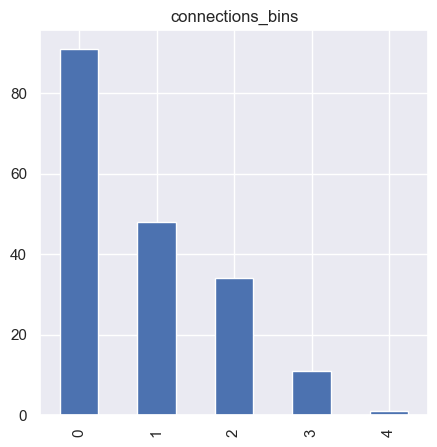

0    64
1    53
2    34
3    21
4    10
5     3
Name: funding_rounds_bins, dtype: int64


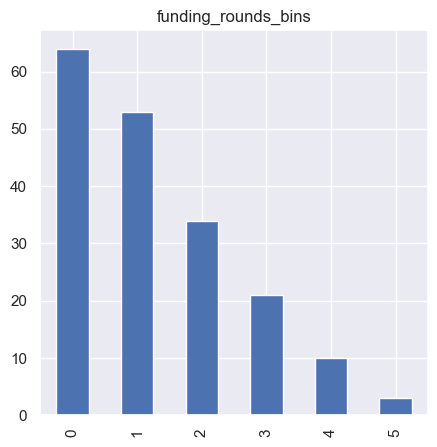

0    77
1    48
2    46
3    10
4     3
5     1
Name: milestones_bins, dtype: int64


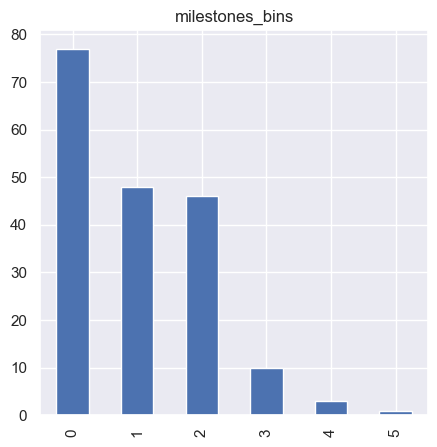

1    85
0    44
2    30
3    21
4     5
Name: avg_group_size_bins, dtype: int64


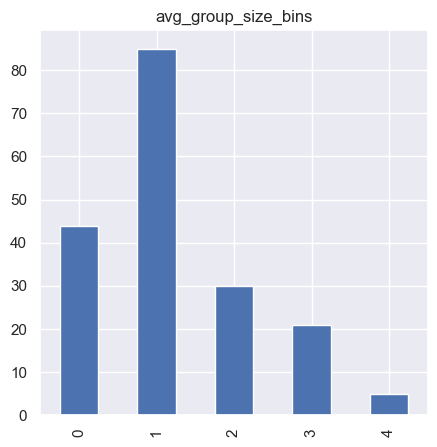

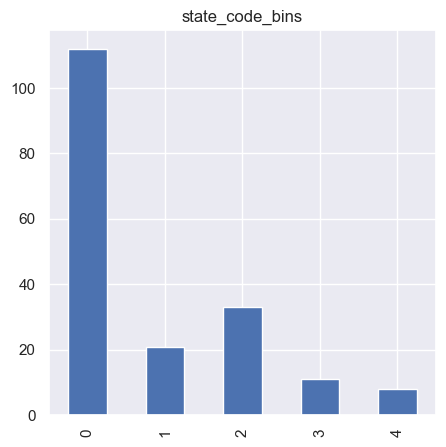

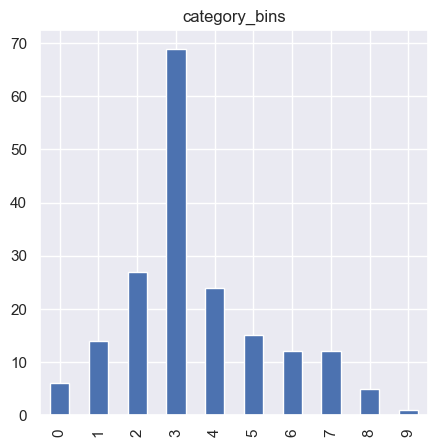

discretize train data
0    376
1    193
2    121
3     35
4     13
Name: connections_bins, dtype: int64


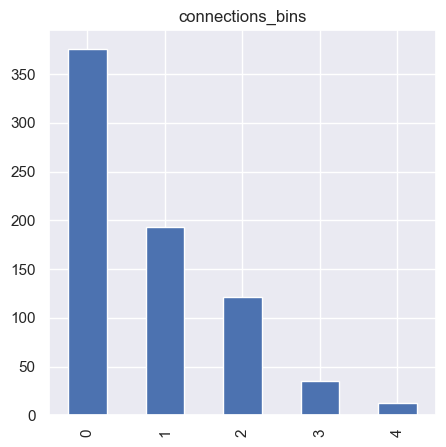

0    253
1    227
2    133
3     69
4     43
5     13
Name: funding_rounds_bins, dtype: int64


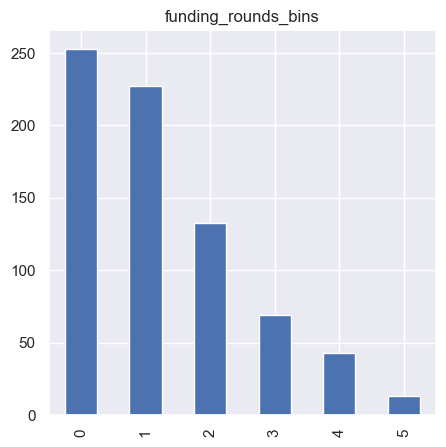

0    325
1    198
2    136
3     52
4     21
5      6
Name: milestones_bins, dtype: int64


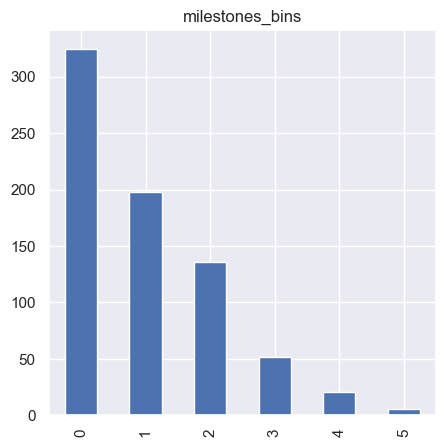

1    338
0    172
2    170
3     43
4     15
Name: avg_group_size_bins, dtype: int64


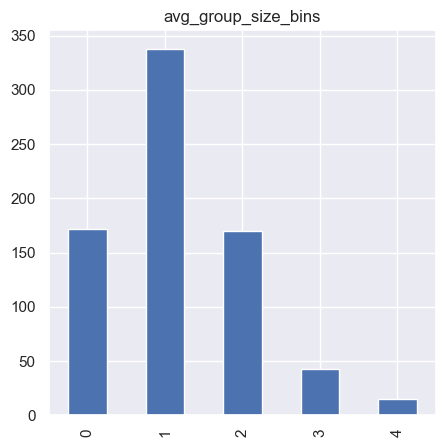

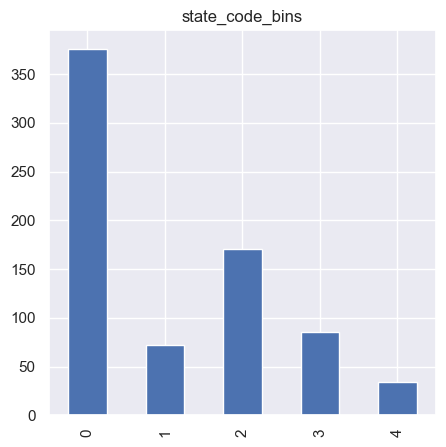

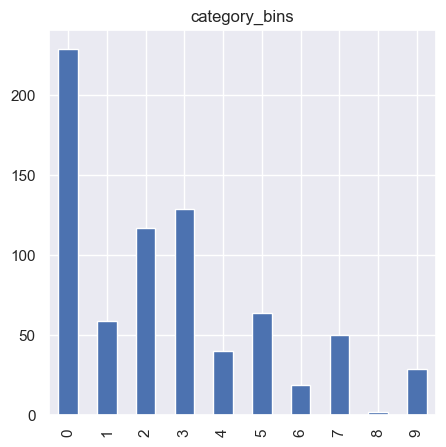

In [24]:
def discretize_and_plot(df):
    """discretize the data and plot the results"""
    connections = [0, 5, 10, 20, 30, df['connections'].max()]
    discretize(df, 'connections', connections)

    funding_rounds = [0, 1, 2, 3, 4, 6, df['funding_rounds'].max()]
    discretize(df, 'funding_rounds', funding_rounds)

    milestones = [0, 1, 2, 3, 4, 5, df['milestones'].max()]
    discretize(df, 'milestones', milestones)

    avg_group_size = [0, 1, 3, 5, 8, df['avg_group_size'].max()]
    discretize(df, 'avg_group_size', avg_group_size)

    df['state_code_bins'] = df['country'].map({state: i for i, state in enumerate(df['country'].unique())})
    plt.title('state_code_bins')
    df['state_code_bins'].value_counts().sort_index().plot.bar()
    plt.show()

    for col in COLUMNS_IS_CATEGORY:
        df.loc[df[col]==1, 'category_1'] = col.strip("is_")
    df['category_bins'] = df['category_1'].map({state: i for i, state in enumerate(df['category_1'].unique())})
    plt.title('category_bins')
    df['category_bins'].value_counts().sort_index().plot.bar()
    plt.show()

for n, df in dfs2clean.items():
    print(f"discretize {n} data")
    discretize_and_plot(df)


### Drop columns

In [36]:
def drop_columns(df):
    """drop columns that are not needed"""
    df = df.copy()
    droppings = ['id', 'state_code', 'latitude', 'longitude', 'zip_code', 'city', 'name',
       'first_funding_date', 'last_funding_date', 'connections', 'funding_rounds', 
       'milestones', 'category', 'avg_group_size', 'avg_group_size', 
       'state_code_codes', 'category_codes', 'city_codes', 
       'country', 'in_Top500_str', 'category_1'] + COLUMNS_IN_STATE + COLUMNS_IS_CATEGORY  # and nominal data-s
    return df.drop(set(droppings) & set(df.columns), axis=1)

dfs_after_cleaning: dict = {}
for n, df in dfs2clean.items():
    print(f"Columns after dropping - {n} data")
    dfs_after_cleaning[n] = x = drop_columns(df)
    print(x.columns,end="\n\n")

Columns after dropping - test data
Index(['foundation_date', 'first_funding_age', 'last_funding_age',
       'first_milestone_age', 'last_milestone_age', 'total_funding', 'roundA',
       'roundB', 'roundC', 'roundD', 'in_Top500', 'no_milestones',
       'connections_bins', 'funding_rounds_bins', 'milestones_bins',
       'avg_group_size_bins', 'state_code_bins', 'category_bins'],
      dtype='object')

Columns after dropping - train data
Index(['foundation_date', 'first_funding_age', 'last_funding_age',
       'first_milestone_age', 'last_milestone_age', 'total_funding', 'roundA',
       'roundB', 'roundC', 'roundD', 'in_Top500', 'Target', 'no_milestones',
       'connections_bins', 'funding_rounds_bins', 'milestones_bins',
       'avg_group_size_bins', 'state_code_bins', 'category_bins'],
      dtype='object')



In [38]:
dfs_after_cleaning['train'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   foundation_date      738 non-null    datetime64[ns]
 1   first_funding_age    738 non-null    float64       
 2   last_funding_age     738 non-null    float64       
 3   first_milestone_age  738 non-null    float64       
 4   last_milestone_age   738 non-null    float64       
 5   total_funding        738 non-null    int64         
 6   roundA               738 non-null    int64         
 7   roundB               738 non-null    int64         
 8   roundC               738 non-null    int64         
 9   roundD               738 non-null    int64         
 10  in_Top500            738 non-null    int64         
 11  Target               738 non-null    object        
 12  no_milestones        738 non-null    float64       
 13  connections_bins     738 non-null  

In [39]:
dfs_after_cleaning['test'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   foundation_date      185 non-null    datetime64[ns]
 1   first_funding_age    185 non-null    float64       
 2   last_funding_age     185 non-null    float64       
 3   first_milestone_age  185 non-null    float64       
 4   last_milestone_age   185 non-null    float64       
 5   total_funding        185 non-null    int64         
 6   roundA               185 non-null    int64         
 7   roundB               185 non-null    int64         
 8   roundC               185 non-null    int64         
 9   roundD               185 non-null    int64         
 10  in_Top500            185 non-null    int64         
 11  no_milestones        185 non-null    float64       
 12  connections_bins     185 non-null    category      
 13  funding_rounds_bins  185 non-null  

### Normalization

First we need to fix the date columns, because they are not in the correct format - not a number

In [45]:
# transform the data columns to be numeric, so we can normalize them :)
for n, df in dfs_after_cleaning.items():
    df['foundation_date'] = df['foundation_date'].astype('int64')
    print(f"=== Info of {n} ===")
    data_frame_train_clean.info()
    print()

=== Info of test ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   foundation_date      738 non-null    datetime64[ns]
 1   first_funding_age    738 non-null    float64       
 2   last_funding_age     738 non-null    float64       
 3   first_milestone_age  738 non-null    float64       
 4   last_milestone_age   738 non-null    float64       
 5   total_funding        738 non-null    int64         
 6   roundA               738 non-null    int64         
 7   roundB               738 non-null    int64         
 8   roundC               738 non-null    int64         
 9   roundD               738 non-null    int64         
 10  in_Top500            738 non-null    int64         
 11  Target               738 non-null    object        
 12  no_milestones        738 non-null    float64       
 13  connections_bi

Before we'll normalize the column of the total_funding we need to fix the outlier in it, because they will affect the normalization!
In order to do that, we will replace the outlier that we found earlier with the upper bound of the outlier in the column.

In [46]:
def fix_out_total_funding(df):
    """Fix the total_funding column in the given dataframe"""
    lb, ub, o = find_outliers(df=df, col='total_funding')
    row = o.index.tolist()
    df.loc[row, 'total_funding'] = ub

In [48]:
for df in dfs_after_cleaning.values():
    fix_out_total_funding(df)

In [56]:
def normalize(data_f: pd.DataFrame, col_name: str) -> None:
    min_max_scaler = MinMaxScaler()  # min-max scaler normalizer between 0 and 1 :)
    min_max_scaler.fit(pd.DataFrame(data_f[col_name]))
    data_f[col_name] = min_max_scaler.transform(pd.DataFrame(data_f[col_name]))

def normalize_df(df):
    for col in df.columns:  # normalize all the columns that are not binary and not bins
        if df[col].nunique() > 2 and "_bins" not in col:  # check if not-binary and not bins
            normalize(df, col)

for n, df in dfs_after_cleaning.items():
    print(f"Normalize {n} data...", end="\t")
    normalize_df(df)
    print("done.")

Normalize test data...	done.
Normalize train data...	done.


In [57]:
dfs_after_cleaning['train'].head()

,foundation_date,first_funding_age,last_funding_age,first_milestone_age,last_milestone_age,total_funding,roundA,roundB,roundC,roundD,in_Top500,Target,no_milestones,connections_bins,funding_rounds_bins,milestones_bins,avg_group_size_bins,state_code_bins,category_bins
0,0.785287,0.365061,0.389409,0.484841,0.370577,0.000548,0,0,0,0,0,acquired,0.0,0,2,2,0,0,0
1,0.546270,0.458030,0.615461,0.544988,0.381127,0.060504,0,1,1,1,1,acquired,0.0,1,3,0,2,0,1
2,0.860722,0.325749,0.325749,0.402200,0.213102,0.003906,1,0,0,0,1,acquired,0.0,0,0,1,2,0,2
3,0.614601,0.393572,0.464142,0.519179,0.346024,0.060353,0,1,1,1,1,acquired,0.0,0,2,0,2,0,3
4,0.907553,0.292368,0.346291,0.365677,0.137242,0.001944,0,0,0,0,1,closed,0.0,0,1,0,0,0,4


In [58]:
dfs_after_cleaning['test'].head()

,foundation_date,first_funding_age,last_funding_age,first_milestone_age,last_milestone_age,total_funding,roundA,roundB,roundC,roundD,in_Top500,no_milestones,connections_bins,funding_rounds_bins,milestones_bins,avg_group_size_bins,state_code_bins,category_bins
0,0.628663,0.130158,0.157181,0.558369,0.525147,0.009513,1,0,0,0,1,1.0,0,1,0,0,0,0
1,0.701841,0.401533,0.354502,0.563645,0.680018,0.169949,0,0,0,0,1,0.0,1,0,1,0,0,1
2,0.677342,0.125193,0.107546,0.408736,0.480044,0.035591,1,0,0,0,1,0.0,2,1,1,4,0,2
3,0.877342,0.182492,0.118247,0.474308,0.513133,0.062236,1,0,0,0,1,0.0,1,0,1,3,0,0
4,0.760448,0.484776,0.444287,0.579696,0.545205,0.119734,1,0,0,0,0,0.0,1,0,0,0,0,3


## 2) Split the data to train and validation set and use cross-validation method, show the differences between iterations.

In [59]:
def evaluate(X, y, clf):
    X = X.to_numpy()
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # cm, accuracy, recall, precision = [], [], [], []
    our_metrics = {'cm': [[], []], 'accuracy': [[], []], 'recall': [[], []], 'precision': [[], []]}

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        for i, (curr_x, curr_y) in enumerate([(X_train, y_train), (X_test, y_test)]):
            clf.fit(X_train, y_train)
            y_pred = clf.predict(curr_x)
            our_metrics['cm'][i].append(metrics.confusion_matrix(curr_y, y_pred))
            our_metrics['accuracy'][i].append(metrics.accuracy_score(curr_y, y_pred))
            our_metrics['recall'][i].append(metrics.recall_score(curr_y, y_pred, average='weighted'))
            our_metrics['precision'][i].append(metrics.precision_score(curr_y, y_pred, average='weighted'))
        
        
        # clf.fit(X_train, y_train)
        
        # y_pred = clf.predict(X_test)
        # cm.append(metrics.confusion_matrix(y_test, y_pred))
        # accuracy.append(metrics.accuracy_score(y_test, y_pred))
        # recall.append(metrics.recall_score(y_test, y_pred, average='weighted'))
        # precision.append(metrics.precision_score(y_test, y_pred, average='weighted'))
    
    results = {
        'train': {
        'Accuracy': our_metrics['accuracy'][0],
        'Recall': our_metrics['recall'][0],
        'Precision': our_metrics['precision'][0] },
        'test': {
        'Accuracy': our_metrics['accuracy'][1],
        'Recall': our_metrics['recall'][1],
        'Precision': our_metrics['precision'][1] }
    }

    for key in results:
        print(f"Metrics for {key} set:")
        results_df = pd.DataFrame(results[key])
        mean_results = results_df.mean().to_frame().T
        mean_results.index = ['Mean']
        results_df = pd.concat([results_df, mean_results])
        # results_df = results_df.append(mean_results)
        display(HTML(results_df.to_html()))

def split_train_result(df):
    X = df.drop(columns='Target')
    y = df['Target']
    return X, y

def create_dummies(df):
    dummies_col = []
    for col in df:
        unique_values = len(df[col].unique())
        if 2 < unique_values < 8:
            dummies_col.append(col)

    return pd.get_dummies(data=df, columns=dummies_col)

Check the classic Decision Tree Classifier on our data split to train and validation set.

In [ ]:
X, y = split_train_result(data_frame_train_clean)
evaluate(X, y, clf=DecisionTreeClassifier(random_state=42))

We can see that the accuracy is not so good and we've got overfitting, so we'll try to improve it, by finding the best depth for the tree.

In [ ]:
def findMaxDepth(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    train_scores, test_scores = [], []
    for k in range(2,25):
        clf3 = DecisionTreeClassifier(criterion='entropy', splitter='best', 
                            max_depth=k, min_samples_split=15, min_samples_leaf=5, random_state=42)
        clf3.fit(X_train, y_train)
        train_scores.append(clf3.score(X_train, y_train))
        test_scores.append(clf3.score(X_test, y_test))

    plt.figure(figsize=(8, 6))
    plt.plot(range(2,25), train_scores)
    plt.plot(range(2,25), test_scores)
    plt.xticks(range(2,25))
    plt.legend(['train', 'test'])
    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
    plt.show()
    
    return np.argmax(test_scores) + 2

In [ ]:
X, y = split_train_result(data_frame_train_clean)
best_depth = findMaxDepth(X, y)
best_depth

Split the data and check the accuracy of the decision tree model on the validation set - find the best depth for the tree.

The best depth is 6-7 or 9-11, so we'll use 6 for the decision tree model.

In [ ]:
X, y = split_train_result(data_frame_train_clean)
evaluate(X, y, clf=DecisionTreeClassifier(criterion='entropy', splitter='best', 
                            max_depth=best_depth, min_samples_split=15, min_samples_leaf=5, random_state=42))

We can see that now we don't have overfitting and the accuracy of the test (of the cross validation) is better.

## Decision Tree Classifier

Now let's check the accuracy of the decision tree model with this depth on the train set with dummies.

In [ ]:
dummies_df = create_dummies(data_frame_train_clean)
X, y = split_train_result(dummies_df)
evaluate(X, y, clf=DecisionTreeClassifier(criterion='entropy', splitter='best', 
                            max_depth=6, min_samples_split=15, min_samples_leaf=5, random_state=42))

Overall the dummies didn't help us, so we'll continue without them. 

Our accuracy isn't very good, so we'll try to improve it by using a hyperparameter tuning.

In [ ]:
clf = DecisionTreeClassifier(random_state=42)
clf.get_params()

In [ ]:
criterion = ['gini', 'entropy']
max_depth = list(range(5, 12))
min_samples_split = list(range(11, 17))
min_samples_leaf = list(range(4, 7))
splitter = ['best', 'random']
random_stats = list(range(101))

param_grid = {'criterion': criterion,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'splitter' : splitter,
               'min_samples_leaf': min_samples_leaf,
               'random_state': random_stats
               }

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

dt_random = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter=100, cv=5,
                                verbose=2, random_state=42, n_jobs=-1)

dt_random.fit(X_train, y_train)

In [ ]:
dt_random.best_params_

In [ ]:
clf.fit(X_train, y_train)
dt_y_pred = clf.predict(X_test)
dt_accuracy = metrics.accuracy_score(y_test, dt_y_pred)
print('base model accuracy = {:0.2f}%'.format(dt_accuracy*100))

best_random = dt_random.best_estimator_
random_y_pred = best_random.predict(X_test)
random_accuracy = metrics.accuracy_score(y_test, random_y_pred)
print('random model accuracy = {:0.2f}%'.format(random_accuracy*100))

print('Improvement of {:0.2f}%.'.format(100 * (random_accuracy - dt_accuracy) / dt_accuracy))

In [ ]:
dt_grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

dt_grid.fit(X_train, y_train)

In [ ]:
dt_grid.best_params_

In [ ]:
clf.fit(X_train, y_train)
dt_y_pred = clf.predict(X_test)
dt_accuracy = metrics.accuracy_score(y_test, dt_y_pred)
print('base model accuracy = {:0.2f}%'.format(dt_accuracy*100))

best_grid = dt_grid.best_estimator_
random_y_pred = best_grid.predict(X_test)
random_accuracy = metrics.accuracy_score(y_test, random_y_pred)
print('random model accuracy = {:0.2f}%'.format(random_accuracy*100))

print('Improvement of {:0.2f}%.'.format(100 * (random_accuracy - dt_accuracy) / dt_accuracy))